<center><h1>CryptoCurrency Forecasting (Bitcoin vs Ethereum vs XRP)</h1></center>
<center><h2>(A comparison analysis)</h2></center>
<center><h3>By Mayra Munguia & Jesús Cárdenas</h3></center>

El propósito general de este proyecto es realizar un análisis y previamente crear un modelo de predicción de precio de cierre diario de 3 divisas distintas (XRP, Ethereum y Bitcoin) usando como data de entrenamiento los valores que tuvieron las divisas pre- y durante la pandemia y analizando las divisas para ver si el COVID realmente afectó la tendencia.

Se usará el Facebook Prophet el cual es un algoritmo open source el cual es bastante bueno para generar modelos de predicción de series de tiempo que muestran tendencias por temporadas.


In [20]:
#Se importan las librerías que vamos a utilizar...
!python -m pip install --user pyspark
!python -m pip install --user tqdm
!python -m pip install --user matplotlib
!python -m pip install --user pyArrow
!python -m pip install --user sklearn
!python -m pip install --user seaborn
!python -m pip install --user hmmlearn
!python -m pip install --user itertools
!python -m pip install --user json

ERROR: Could not find a version that satisfies the requirement itertools (from versions: none)
ERROR: No matching distribution found for itertools
ERROR: Could not find a version that satisfies the requirement json (from versions: none)
ERROR: No matching distribution found for json


In [110]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import pyspark.pandas as ps
import numpy as np
from sklearn.model_selection import train_test_split
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'figure.figsize':(7,5),'figure.dpi':100})
import seaborn as sns
sns.set_style("white")
import os
#os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"
from hmmlearn.hmm import GaussianHMM
from sklearn.model_selection import train_test_split
import itertools
from tqdm import tqdm
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import json

In [111]:
#Se hace ela lectura de los datos
df_BTC = pd.read_csv("coin_Bitcoin.csv")
df_BTC = df_BTC.tail(500)
df_BTC.shape
df_BTC['Date'] = pd.to_datetime(df_BTC['Date'])

In [112]:
df_ET = pd.read_csv("coin_Ethereum.csv")
df_ET = df_ET.tail(500)
df_ET.shape
df_ET['Date'] = pd.to_datetime(df_ET['Date'])

In [113]:
df_XRP = pd.read_csv("coin_XRP.csv")
df_XRP = df_XRP.tail(500)
df_XRP.shape
df_XRP['Date'] = pd.to_datetime(df_XRP['Date'])

In [114]:
df_BTC.shape

(500, 10)

<Figure size 700x500 with 0 Axes>

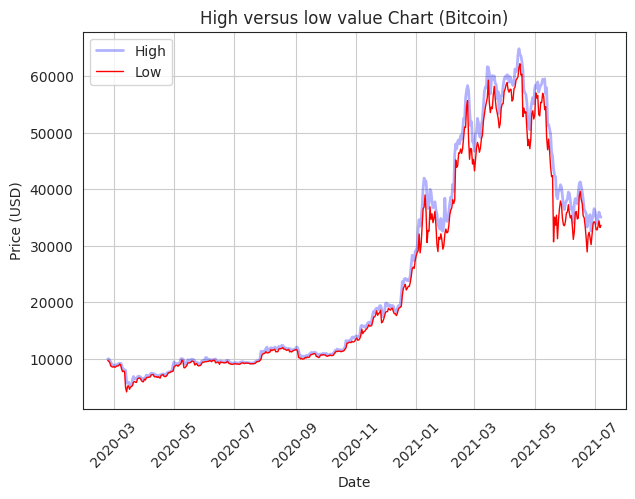

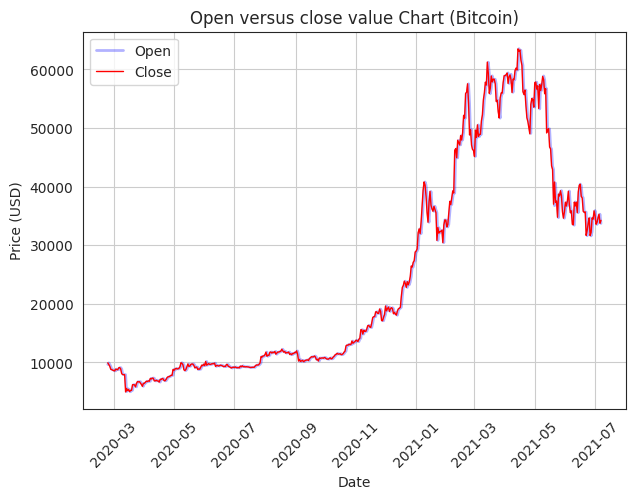

<Figure size 700x500 with 0 Axes>

In [115]:
#graficas de comportamiento de las variables
plt.plot(df_BTC['Date'],df_BTC['High'], "blue", linewidth=2, alpha=0.3,label='High')
plt.plot(df_BTC['Date'],df_BTC['Low'], "red", linewidth=1,label='Low')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('High versus low value Chart (Bitcoin)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.figure(200)
plt.plot(df_BTC['Date'],df_BTC['Open'], "blue", linewidth=2, alpha=0.3,label='Open')
plt.plot(df_BTC['Date'],df_BTC['Close'], "red", linewidth=1,label='Close')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('Open versus close value Chart (Bitcoin)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.figure(300)



<Figure size 700x500 with 0 Axes>

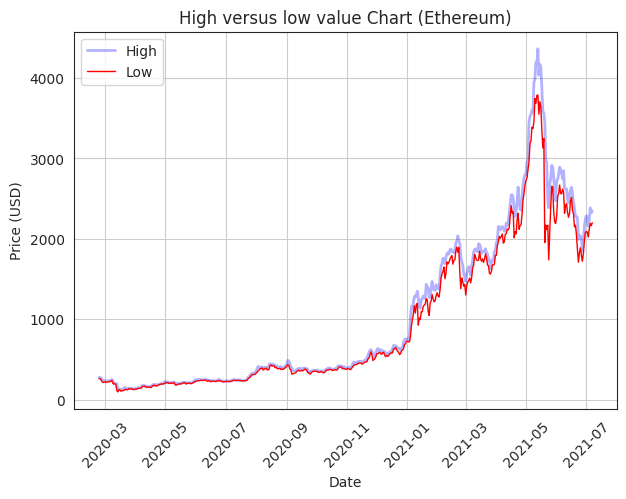

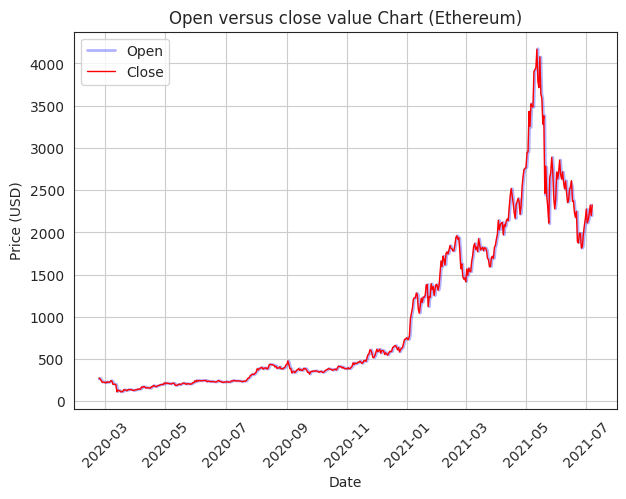

<Figure size 700x500 with 0 Axes>

In [116]:
plt.plot(df_ET['Date'],df_ET['High'], "blue", linewidth=2, alpha=0.3,label='High')
plt.plot(df_ET['Date'],df_ET['Low'], "red", linewidth=1,label='Low')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('High versus low value Chart (Ethereum)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.figure(200)
plt.plot(df_ET['Date'],df_ET['Open'], "blue", linewidth=2, alpha=0.3,label='Open')
plt.plot(df_ET['Date'],df_ET['Close'], "red", linewidth=1,label='Close')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('Open versus close value Chart (Ethereum)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.figure(300)

<Figure size 700x500 with 0 Axes>

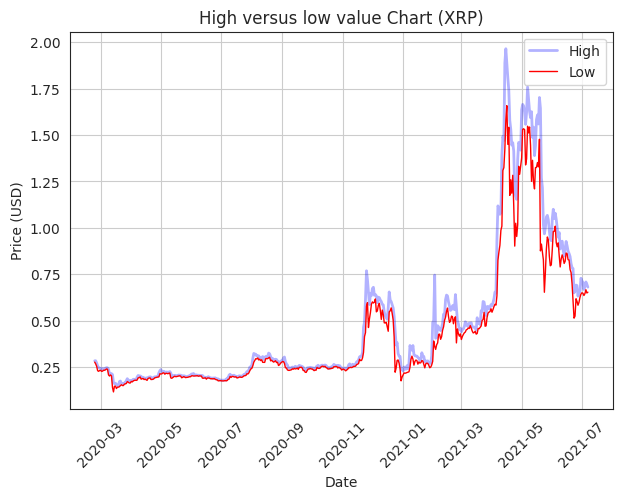

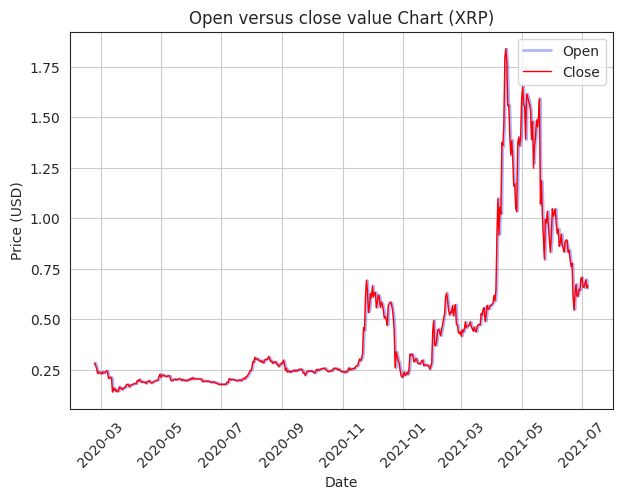

<Figure size 700x500 with 0 Axes>

In [117]:
plt.plot(df_XRP['Date'],df_XRP['High'], "blue", linewidth=2, alpha=0.3,label='High')
plt.plot(df_XRP['Date'],df_XRP['Low'], "red", linewidth=1,label='Low')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('High versus low value Chart (XRP)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.figure(200)
plt.plot(df_XRP['Date'],df_XRP['Open'], "blue", linewidth=2, alpha=0.3,label='Open')
plt.plot(df_XRP['Date'],df_XRP['Close'], "red", linewidth=1,label='Close')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('Open versus close value Chart (XRP)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.figure(300)

Text(0.5, 1.0, 'Marketcap mean')

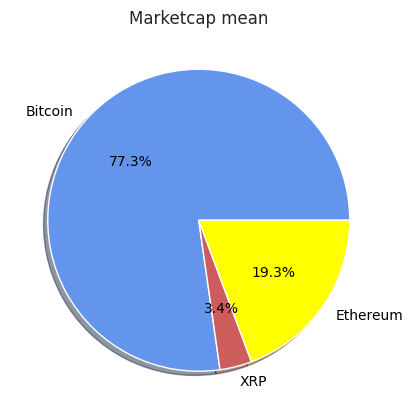

In [118]:
mrkCaps=[df_BTC['Marketcap'].mean(),df_XRP['Marketcap'].mean(),df_ET['Marketcap'].mean()]
labelList=['Bitcoin','XRP','Ethereum']
colors=['cornflowerblue','indianred','yellow']
plt.pie(mrkCaps,labels=labelList,colors=colors,autopct='%0.1f%%',shadow=True,textprops={'color':"black"})
plt.title('Marketcap mean')

Text(0.5, 1.0, 'Volume mean')

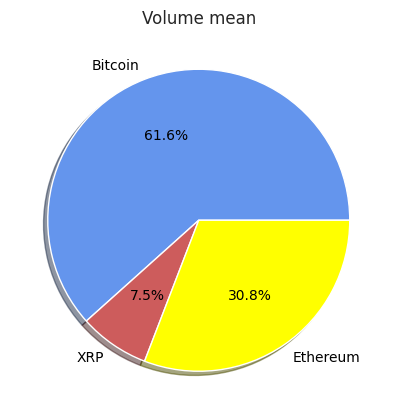

In [119]:
volumes=[df_BTC['Volume'].mean(),df_XRP['Volume'].mean(),df_ET['Volume'].mean()]
labelList=['Bitcoin','XRP','Ethereum']
colors=['cornflowerblue','indianred','yellow']
plt.pie(volumes,labels=labelList,colors=colors,autopct='%0.1f%%',shadow=True,textprops={'color':"black"})
plt.title('Volume mean')

In [120]:
files_to_use = ["coin_Bitcoin.csv", "coin_Ethereum.csv","coin_XRP.csv"]

cols_to_use = []
for ind, file_name in enumerate(files_to_use):
    currency_name = file_name.split("_")[1]
    if ind == 0:
        df = pd.read_csv(file_name, usecols=["Date", "Close"])
        df.columns = ["Date", currency_name]
    else:
        temp_df = pd.read_csv(file_name, usecols=["Date", "Close"])
        temp_df.columns = ["Date", currency_name]
        df = pd.merge(df, temp_df, on="Date")
    cols_to_use.append(currency_name)
df.head()
    

,Date,Bitcoin.csv,Ethereum.csv,XRP.csv
0,2015-08-08 23:59:59,260.997009,0.753325,0.008476
1,2015-08-09 23:59:59,265.083008,0.701897,0.008808
2,2015-08-10 23:59:59,264.470001,0.708448,0.008750
3,2015-08-11 23:59:59,270.385986,1.067860,0.008591
4,2015-08-12 23:59:59,266.376007,1.217440,0.008271


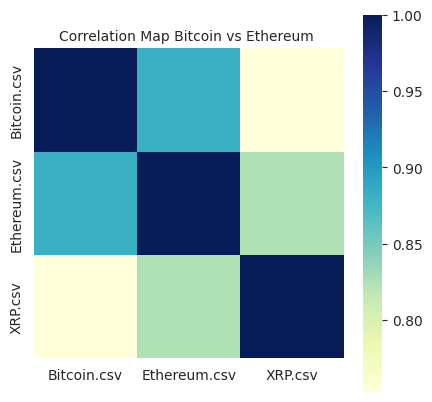

In [121]:
temp_df = df[cols_to_use]
corrmat = temp_df.corr(method='spearman')
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(corrmat, vmax=1., square=True, cmap="YlGnBu")
plt.title("Correlation Map Bitcoin vs Ethereum ", fontsize=10)
plt.show()

Text(0, 0.5, 'Price (USD)')

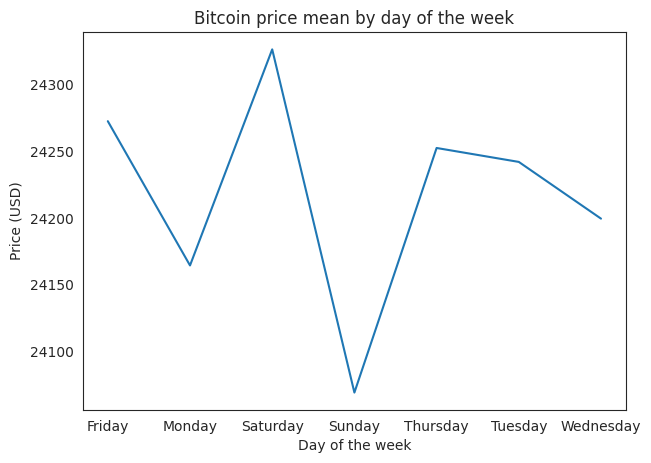

In [122]:
df_BTC['weekday'] = pd.to_datetime(df_BTC['Date']).dt.day_name()
week_data = df_BTC.groupby(['weekday'], as_index=False)['Close'].agg({'mean': 'mean'})
day_of_week = pd.DataFrame(data=week_data)


plt.plot(figsize=(8,4),dpi=80)
plt.title('Bitcoin price mean by day of the week')

my_xticks = np.array(day_of_week.weekday)
plt.xticks(range(len(week_data['mean'])), my_xticks)
plt.plot(range(len(week_data['mean'])), week_data['mean'])
plt.xlabel('Day of the week')
plt.ylabel('Price (USD)')

Text(0, 0.5, 'Price (USD)')

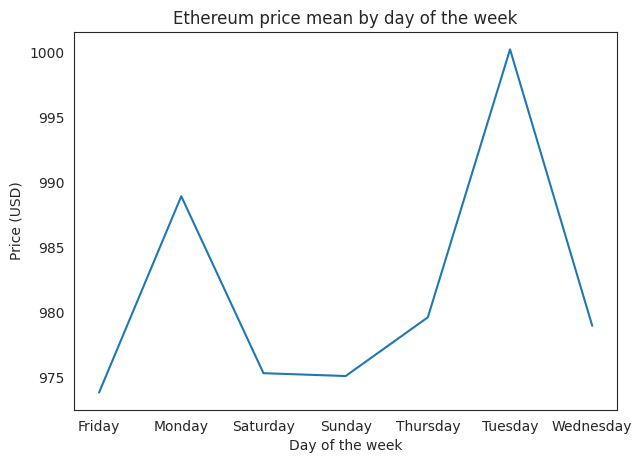

In [123]:
df_ET['weekday'] = pd.to_datetime(df_ET['Date']).dt.day_name()
week_data = df_ET.groupby(['weekday'], as_index=False)['Close'].agg({'mean': 'mean'})
day_of_week = pd.DataFrame(data=week_data)


plt.plot(figsize=(5,10))
plt.title('Ethereum price mean by day of the week')

my_xticks = np.array(day_of_week.weekday)
plt.xticks(range(len(week_data['mean'])), my_xticks)
plt.plot(range(len(week_data['mean'])), week_data['mean'])
plt.xlabel('Day of the week')
plt.ylabel('Price (USD)')

Text(0, 0.5, 'Price (USD)')

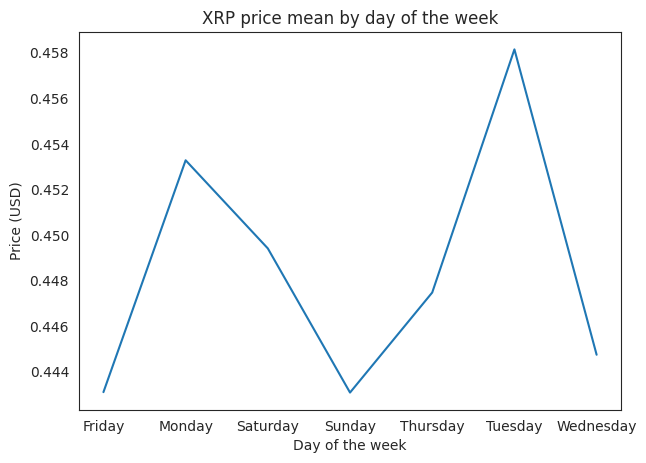

In [124]:
df_XRP['weekday'] = pd.to_datetime(df_XRP['Date']).dt.day_name()
week_data = df_XRP.groupby(['weekday'], as_index=False)['Close'].agg({'mean': 'mean'})
day_of_week = pd.DataFrame(data=week_data)


plt.plot(figsize=(5,10))
plt.title('XRP price mean by day of the week')

my_xticks = np.array(day_of_week.weekday)
plt.xticks(range(len(week_data['mean'])), my_xticks)
plt.plot(range(len(week_data['mean'])), week_data['mean'])
plt.xlabel('Day of the week')
plt.ylabel('Price (USD)')

<center><h1>CryptoCurrency Forecasting P2</h1></center>
<center><h2>Prophet Model</h2></center>

## Bitcoin

In [125]:
dfs_BTC=spark.read.json("BTC_USDT-1m.json") #Se cargan los archivos tipo json

In [126]:
dfs_BTC.printSchema()

root
 |-- _corrupt_record: string (nullable = true)



In [127]:

start_date = '1/1/2019  11:59:59 PM'
end_date = '7/6/2021  11:59:59 PM'
mask = (df_BTC['Date'] >= start_date) & (df_BTC['Date'] <= end_date)
latestBTC=df_BTC.loc[mask]

In [128]:
#Hacemos dos subset, uno con solo la data de 2019-202o para train y otra de solo 2021 para testing
start_date = '1/1/2019  11:59:59 PM'
end_date = '1/1/2021  11:59:59 PM'
mask = (latestBTC['Date'] >= start_date) & (latestBTC['Date'] < end_date)
df=latestBTC.loc[mask]
df.head()

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap,weekday
2491,2492,Bitcoin,BTC,2020-02-23 23:59:59,9937.404106,9657.791145,9663.318642,9924.515228,4.118519e+10,1.809632e+11,Sunday
2492,2493,Bitcoin,BTC,2020-02-24 23:59:59,9951.746149,9537.043223,9921.583461,9650.174807,4.508050e+10,1.759778e+11,Monday
2493,2494,Bitcoin,BTC,2020-02-25 23:59:59,9652.736865,9305.021186,9651.312799,9341.705169,4.251526e+10,1.703696e+11,Tuesday
2494,2495,Bitcoin,BTC,2020-02-26 23:59:59,9354.778310,8704.426551,9338.290280,8820.522200,5.042005e+10,1.608795e+11,Wednesday
2495,2496,Bitcoin,BTC,2020-02-27 23:59:59,8932.893047,8577.199309,8825.093518,8784.493849,4.547020e+10,1.602385e+11,Thursday


In [129]:
start_date = '1/1/2021  11:59:59 PM'
end_date = '31/12/2021  11:59:59 PM'
mask = (df_BTC['Date'] >= start_date) & (df_BTC['Date'] <= end_date)
test=df_BTC.loc[mask]
test.head()

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap,weekday
2804,2805,Bitcoin,BTC,2021-01-01 23:59:59,29600.626950,28803.585014,28994.008916,29374.151889,4.073030e+10,5.460016e+11,Friday
2805,2806,Bitcoin,BTC,2021-01-02 23:59:59,33155.118819,29091.181191,29376.455834,32127.267939,6.786542e+10,5.972059e+11,Saturday
2806,2807,Bitcoin,BTC,2021-01-03 23:59:59,34608.556738,32052.317076,32129.407356,32782.024466,7.866524e+10,6.094092e+11,Sunday
2807,2808,Bitcoin,BTC,2021-01-04 23:59:59,33440.218569,28722.755271,32810.947644,31971.913522,8.116348e+10,5.943840e+11,Monday
2808,2809,Bitcoin,BTC,2021-01-05 23:59:59,34437.590592,30221.186739,31977.041132,33992.429344,6.754732e+10,6.319800e+11,Tuesday


<Figure size 700x500 with 0 Axes>

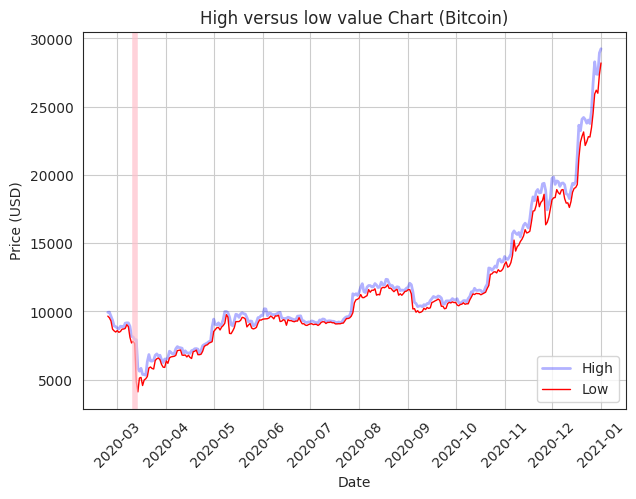

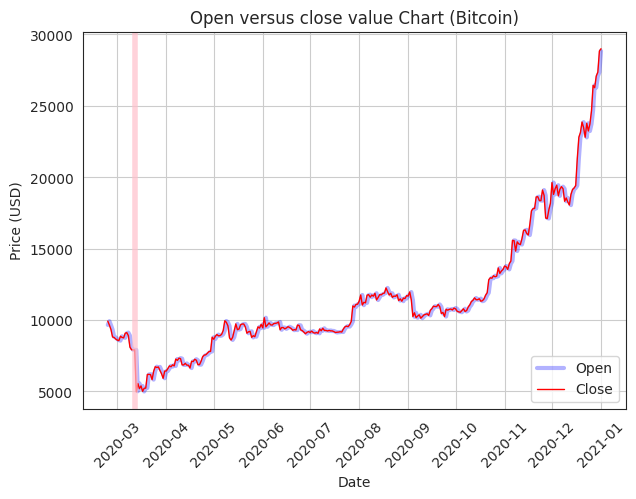

<Figure size 700x500 with 0 Axes>

In [161]:
#Ploteamos solo la data de 2019-2020 para revisar tendencia y efectos por COVID-19
plt.plot(df['Date'],df['High'], "blue", linewidth=2, alpha=0.3,label='High')
plt.plot(df['Date'],df['Low'], "red", linewidth=1,label='Low')
plt.axvline(pd.Timestamp('2020-03-11 23:59:59'),color='pink',alpha=0.7, linewidth=4)
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('High versus low value Chart (Bitcoin)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.figure(200)
plt.plot(df['Date'],df['Open'], "blue", linewidth=3, alpha=0.3,label='Open')
plt.plot(df['Date'],df['Close'], "red", linewidth=1,label='Close')
plt.axvline(pd.Timestamp('2020-03-11 23:59:59'),color='pink',alpha=0.7, linewidth=4)
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('Open versus close value Chart (Bitcoin)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.figure(300)

In [131]:
!python -m pip install pystan==2.17.1.0
!python -m pip install fbprophet

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [132]:
from pyspark.sql import SparkSession
from fbprophet import Prophet
from pyspark.sql.types import *

## BITCOIN PRICE FORECAST

In [133]:
#BTC dataset
df1 = pd.read_csv('coin_Bitcoin.csv')
df1.head(5)

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09


In [134]:
#spark dataframe creation
spark = SparkSession.builder.appName("BTC").getOrCreate()
dfBTC= spark.createDataFrame(df1)
dfBTC.show()

+---+-------+------+-------------------+------------------+------------------+------------------+------------------+------+---------------+
|SNo|   Name|Symbol|               Date|              High|               Low|              Open|             Close|Volume|      Marketcap|
+---+-------+------+-------------------+------------------+------------------+------------------+------------------+------+---------------+
|  1|Bitcoin|   BTC|2013-04-29 23:59:59|147.48800659179688|             134.0|134.44400024414062| 144.5399932861328|   0.0| 1.6037688645E9|
|  2|Bitcoin|   BTC|2013-04-30 23:59:59|146.92999267578125| 134.0500030517578|             144.0|             139.0|   0.0|  1.542813125E9|
|  3|Bitcoin|   BTC|2013-05-01 23:59:59|139.88999938964844|107.72000122070312|             139.0|116.98999786376952|   0.0|1.29895459375E9|
|  4|Bitcoin|   BTC|2013-05-02 23:59:59| 125.5999984741211| 92.28189849853516|116.37999725341795|105.20999908447266|   0.0|1.16851749525E9|
|  5|Bitcoin|   BTC|

In [135]:
#Objeto temporal para queris
dfBTC.createOrReplaceTempView('BTC')

In [136]:
#Query para selección de la data
sql_statement = '''
  SELECT
    CAST(Date as date) as ds,
    Close as y
  FROM BTC
  ORDER BY ds
  '''

In [137]:
#cambiamos dataset temporal a pandas
history_pd = spark.sql(sql_statement).toPandas()

In [138]:
history_pd = history_pd.dropna()
history_pd.head(10)

,ds,y
0,2013-04-29,144.539993
1,2013-04-30,139.000000
2,2013-05-01,116.989998
3,2013-05-02,105.209999
4,2013-05-03,97.750000
5,2013-05-04,112.500000
6,2013-05-05,115.910004
7,2013-05-06,112.300003
8,2013-05-07,111.500000
9,2013-05-08,113.566002


In [139]:
#Train test split
train=history_pd.sample(frac=0.8)
test=history_pd.drop(train.index)

In [140]:
#definición del modelo
model = Prophet(
    interval_width=0.95,
    growth='linear',
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True,
    seasonality_mode='multiplicative'
)

In [141]:
# se hace fit del modelo con la data de entrenamiento
model.fit(train)

Initial log joint probability = -56.5322


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5622.12    0.00289851       381.418     0.02697           1      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5787.53    0.00418068       1154.77      0.4914      0.4914      261   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5840.81    0.00557588       252.277           1           1      387   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5860.24    0.00599309       791.594      0.3001      0.3001      507   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5866.43    0.00143443       95.9241           1           1      634   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599     

In [142]:
#Se realiza la predicción
future_pd = model.make_future_dataframe(
    periods=598,
    freq='d',
    include_history=True
)

# predict over the dataset
forecast_pd = model.predict(future_pd)

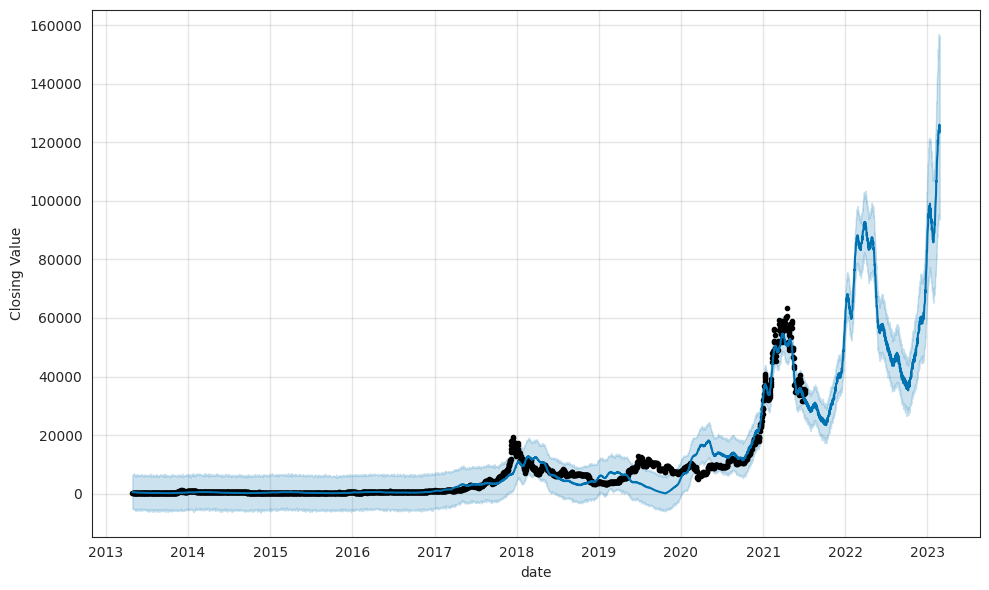

In [143]:
predict_fig = model.plot(forecast_pd, xlabel='date', ylabel='Closing Value')


In [144]:
#Se calcula el error en el calculo
from sklearn.metrics import mean_absolute_error
y_pred=forecast_pd.tail(598)
y_pred=y_pred['yhat']
y_pred.head()
test=test['y']
test.head()
mae = mean_absolute_error(test, y_pred)
print('$ ',mae, 'USD')

$  48621.055720026794 USD


## ETHEREUM PRICE FORECAST

In [145]:
#ETH
df1 = pd.read_csv('coin_Ethereum.csv')
spark = SparkSession.builder.appName("ETH").getOrCreate()
dfETH= spark.createDataFrame(df1)
dfETH.show()

+---+--------+------+-------------------+------------------+------------------+------------------+------------------+---------+---------------+
|SNo|    Name|Symbol|               Date|              High|               Low|              Open|             Close|   Volume|      Marketcap|
+---+--------+------+-------------------+------------------+------------------+------------------+------------------+---------+---------------+
|  1|Ethereum|   ETH|2015-08-08 23:59:59|2.7988100051879883|0.7147250175476074| 2.793760061264038|0.7533249855041504| 674188.0|4.54868942408E7|
|  2|Ethereum|   ETH|2015-08-09 23:59:59|0.8798099756240845| 0.629190981388092|0.7061359882354736|0.7018970251083374| 532170.0|4.23995734991E7|
|  3|Ethereum|   ETH|2015-08-10 23:59:59|0.7298539876937866|0.6365460157394409|0.7139890193939209|0.7084479928016663| 405283.0|4.28183643945E7|
|  4|Ethereum|   ETH|2015-08-11 23:59:59| 1.131410002708435|0.6632350087165833|0.7080870270729065|1.0678600072860718|1463100.0|6.4569288

In [146]:
dfETH.createOrReplaceTempView('ETH')
sql_statement = '''
  SELECT
    CAST(Date as date) as ds,
    Close as y
  FROM ETH
  ORDER BY ds
  '''
history_pd = spark.sql(sql_statement).toPandas()
history_pd = history_pd.dropna()
history_pd.head(10)

,ds,y
0,2015-08-08,0.753325
1,2015-08-09,0.701897
2,2015-08-10,0.708448
3,2015-08-11,1.067860
4,2015-08-12,1.217440
5,2015-08-13,1.827670
6,2015-08-14,1.827870
7,2015-08-15,1.688900
8,2015-08-16,1.566030
9,2015-08-17,1.203610


In [147]:
train=history_pd.sample(frac=0.8)
test=history_pd.drop(train.index)

In [148]:
model2 = Prophet(
    interval_width=0.95,
    growth='linear',
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True,
    seasonality_mode='multiplicative'
)
model2.fit(train)

Initial log joint probability = -49.3929


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5069.05     0.0572251       4591.02      0.4752           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        5231.9    0.00647813       787.929           1           1      256   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        5349.8    0.00507535       491.527      0.6489      0.6489      372   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5394.35   0.000803873       496.378           1           1      494   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5406.16   0.000353254       253.063           1           1      609   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599     

In [149]:
test.shape

(432, 2)

In [150]:
future_pd = model2.make_future_dataframe(
    periods=432,
    freq='d',
    include_history=True
)

# predict over the dataset
forecast_pd = model2.predict(future_pd)

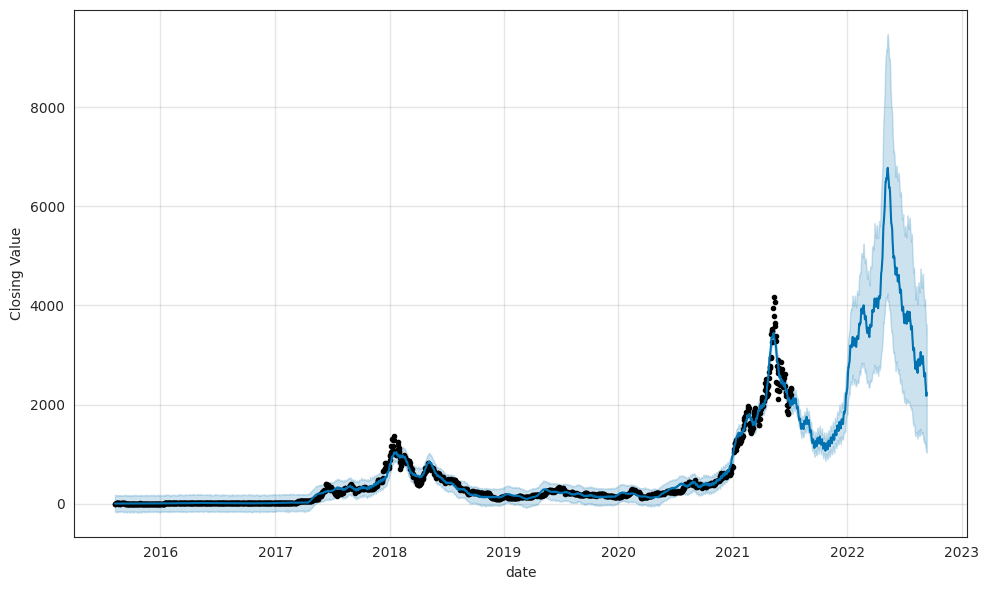

In [151]:
predict_fig = model2.plot(forecast_pd, xlabel='date', ylabel='Closing Value')

In [152]:
#error calc.
from sklearn.metrics import mean_absolute_error
y_pred=forecast_pd.tail(432)
y_pred=y_pred['yhat']
y_pred.head()
test=test['y']
test.head()
mae = mean_absolute_error(test, y_pred)
print('$ ',mae, 'USD')

$  2620.819520029177 USD


## XRP PRICE FORECAST

In [153]:
#ETH
df1 = pd.read_csv('coin_XRP.csv')
spark = SparkSession.builder.appName("XRP").getOrCreate()
dfXRP= spark.createDataFrame(df1)
dfXRP.show()

+---+----+------+-------------------+------------------+------------------+------------------+------------------+------+---------------+
|SNo|Name|Symbol|               Date|              High|               Low|              Open|             Close|Volume|      Marketcap|
+---+----+------+-------------------+------------------+------------------+------------------+------------------+------+---------------+
|  1| XRP|   XRP|2013-08-05 23:59:59|0.0059798401780426|0.0056126601994037|0.0058747800067067|0.0056126601994037|   0.0|  4.387915732E7|
|  2| XRP|   XRP|2013-08-06 23:59:59|0.0056610200554132|0.0046286098659038| 0.005636760033667| 0.004680419806391|   0.0|3.65910077403E7|
|  3| XRP|   XRP|2013-08-07 23:59:59|0.0046820198185741|0.0043326099403202|0.0046692299656569|0.0044173197820782|   0.0| 3.4534120936E7|
|  4| XRP|   XRP|2013-08-08 23:59:59|0.0044240299612283|0.0041752899996936|0.0043966500088572|0.0042541702277958|   0.0|3.32586322164E7|
|  5| XRP|   XRP|2013-08-09 23:59:59|0.00

In [154]:
dfXRP.createOrReplaceTempView('XRP')
sql_statement = '''
  SELECT
    CAST(Date as date) as ds,
    Close as y
  FROM XRP
  ORDER BY ds
  '''
history_pd = spark.sql(sql_statement).toPandas()
history_pd = history_pd.dropna()
history_pd.head(10)

,ds,y
0,2013-08-05,0.005613
1,2013-08-06,0.004680
2,2013-08-07,0.004417
3,2013-08-08,0.004254
4,2013-08-09,0.004291
5,2013-08-10,0.004314
6,2013-08-11,0.004415
7,2013-08-12,0.004449
8,2013-08-13,0.004245
9,2013-08-14,0.003788


In [155]:
train=history_pd.sample(frac=0.8)
test=history_pd.drop(train.index)

In [156]:
model3 = Prophet(
    interval_width=0.95,
    growth='linear',
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True,
    seasonality_mode='multiplicative'
)
model3.fit(train)

Initial log joint probability = -11.3039


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5557.88     0.0188101       2790.52      0.9308      0.9308      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5735.74       0.06406       853.437           1           1      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5761.88    0.00474972       1291.43      0.5332      0.5332      368   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        5775.2    0.00214895       91.5151           1           1      499   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5789.91   0.000631204       251.943     0.01313      0.5106      635   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599     

In [157]:
test.shape

(579, 2)

In [158]:
future_pd = model3.make_future_dataframe(
    periods=579,
    freq='d',
    include_history=True
)

# Se predice el daaset
forecast_pd = model3.predict(future_pd)

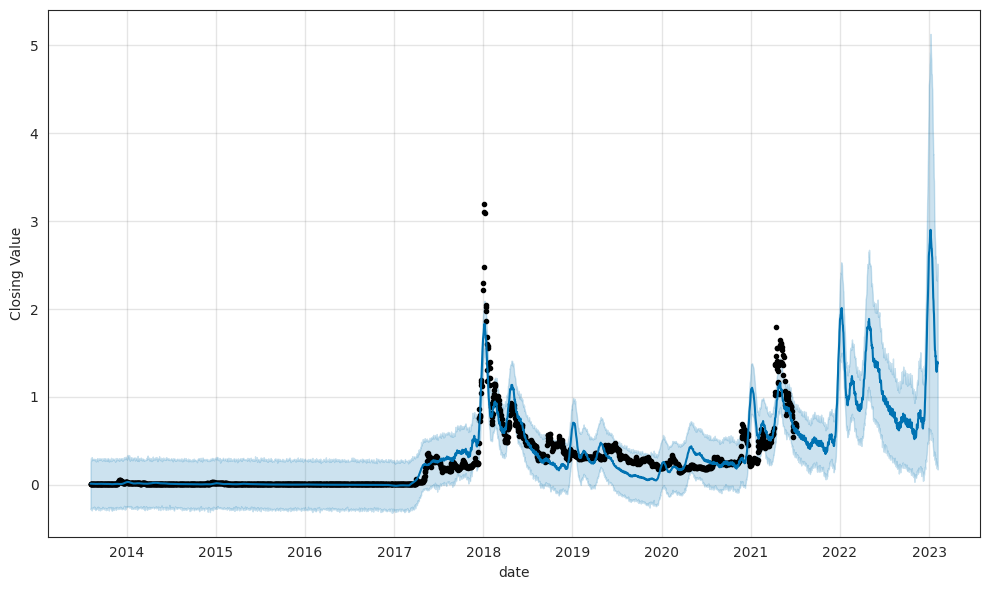

In [159]:
predict_fig = model3.plot(forecast_pd, xlabel='date', ylabel='Closing Value')

In [160]:
#error calc.
from sklearn.metrics import mean_absolute_error
y_pred=forecast_pd.tail(579)
y_pred=y_pred['yhat']
y_pred.head()
test=test['y']
test.head()
mae = mean_absolute_error(test, y_pred)
print('$ ',mae, 'USD')

$  0.7549946582397976 USD


<br>
<br>
<center>
    <img src="https://i.imgur.com/AVqnjug.png" width="150" height="150"/>
</center>